In [1]:
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
cos = nn.CosineSimilarity(dim=0, eps=1e-9)
from torchvision import transforms
# from codes.models import ConvNet, resnet8, MLP
from utils import *
from torch.utils.data import DataLoader
from models import *
import random
from collections import Counter
from collections import OrderedDict
import seaborn as sns
import copy
device = "cuda"


# adjustable parameters
alpha_d = 100
local_ep = 20
mali_local_ep = 20
points = 41
global attack 
attack = "tlp" #"backdoor", "tlp"
model_name = "ConvNet" # "resnet8", "ConvNet"
num_classes = 10
dataset ="fmnist"

In [ ]:
def cos_dist(w1, w2):
    """Compute cosine similarity between two flattened weight tensors"""
    w1_flat, w2_flat = torch.cat([p.view(-1) for p in w1]), torch.cat([p.view(-1) for p in w2])
    return 1 - torch.dot(w1_flat, w2_flat) / (torch.norm(w1_flat) * torch.norm(w2_flat))

def train_tlp_model_new_loss(model0, model1, model3, model0_sd, train_loader, B, L, lr=0.01, epochs=5):
    """Optimize model2 to satisfy constraints"""
    model3.load_state_dict(model0.state_dict())  # Start from model0
    optimizer = optim.SGD(model3.parameters(), lr=lr)
    cos_loss = nn.CosineEmbeddingLoss() 
    w0 = torch.cat([p.clone().detach().view(-1) for p in model0.parameters()]).to(device)
    print(w0.shape)
    w1 = torch.cat([p.clone().detach().view(-1) for p in model1.parameters()]).to(device)

    for epoch in range(epochs):
        for inputs, targets in train_loader:
            # modify 0 to 2
            targets[targets==0] =2 
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            loss = nn.CrossEntropyLoss()(model3(inputs), targets)

            # Compute cosine similarity constraint
            # w2 = [p.clone().detach() for p in model3.parameters()]
            w2 = torch.cat([p.view(-1) for p in model3.parameters()]).to(device)
            # cos_d = cos_dist([w1_i - w0_i for w1_i, w0_i in zip(w1, w0)],
            #                             [w2_i - w0_i for w2_i, w0_i in zip(w2, w0)])
            
            # Target labels: 1 means similar, -1 means dissimilar
            target = torch.ones(len(w0)).to(device)
            c_loss = cos_loss(w1.unsqueeze(1) , w2.unsqueeze(1) , target)

            # Enforce constraint using a soft penalty
            # penalty = torch.relu(cos_d - B) 
            penalty = c_loss
            (loss + L * penalty).backward()
            optimizer.step()
            
            _, cos2 = get_delta_cos(model1, model3, model0_sd)

        print(f"Epoch {epoch+1:02}, Loss: {loss.item():.8f}, Penalty: {L * penalty:11.8f}, Cos: {cos2}")

    return model3


def train_tlp_model_mix_loss(model0, model1, model3, train_loader, budget_B, lambda_tradeoff, lr=0.01, epochs=5):
    """Optimize model2 to satisfy constraints"""
    model3.load_state_dict(model0.state_dict())  # Start from model0
    optimizer = optim.SGD(model3.parameters(), lr=lr)
    cos_loss = nn.CosineEmbeddingLoss() 
    w0 = torch.cat([p.clone().detach().view(-1) for p in model0.parameters()]).to(device)
    print(w0.shape)
    w1 = torch.cat([p.clone().detach().view(-1) for p in model1.parameters()]).to(device)
    delta1 = {name: model1.state_dict()[name] - model0.state_dict()[name] for name in model1.state_dict()}
    
    for epoch in range(epochs):
        print("ep", epoch)
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            # modify 0 to 2
            targets[targets==0] =2 
            inputs, targets = inputs.to(device), targets.to(device)
            

            # Compute weight differences
            delta2 = {name: model3.state_dict()[name] - model0.state_dict()[name] for name in model3.state_dict()}

            # Flatten weight differences for cosine similarity calculation
            delta1_flattened = torch.cat([delta1[name].view(-1) for name in delta1]).to(device)
            delta2_flattened = torch.cat([delta2[name].view(-1) for name in delta2]).to(device)

            # Compute cosine similarity
            cos_d = cos_dist(delta1_flattened, delta2_flattened)
            print("cos_d", cos_d)

            # Compute performance on label-flipped dataset
            outputs = model3(inputs)
            loss_performance = nn.CrossEntropyLoss()(outputs, targets)
            print("loss_performance", loss_performance)

            # Combine into objective function
            objective = loss_performance + lambda_tradeoff * cos_d

            # Backpropagation
            objective.backward()
            optimizer.step()

            # Enforce cosine similarity constraint
            if cos_d > budget_B:
                # Project delta2 back into the feasible region
                scale_factor = budget_B / cos_d
                print("scale_factor", scale_factor)
                for name in model3.state_dict():
                    model3.state_dict()[name] = model0.state_dict()[name] + (model3.state_dict()[name] - model0.state_dict()[name]) * scale_factor


        print(f"Epoch {epoch+1:02}, Loss: {loss_performance.item():.8f}, Penalty: {lambda_tradeoff * cos_d:11.8f}, Cos: {cos_d}")

    return model3


def get_delta_cos(model1, model2, model0_sd):
    flat_model0 = flat_dict(model0_sd)
    flat_model1 = flat_dict(model1.state_dict())
    flat_model2 = flat_dict(model2.state_dict())
    
    delta = torch.abs(flat_model1 - flat_model2)
    org_cos = cos((flat_model1 - flat_model0), (flat_model2 - flat_model0))
    return delta, 1-org_cos.item()

def model_eval(model, test_loader, attack):
    acc = eval_op_ensemble([model], test_loader)
    if attack == "tlp":
        asr = eval_op_ensemble_tr_lf_attack([model], test_loader)
    elif attack == "backdoor":
        asr = eval_op_ensemble_attack([model], test_loader)
    return list(acc.values())[0], list(asr.values())[0]

In [5]:
# Define transformation (convert images to tensors and normalize)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image with mean and std
])

# Load the training dataset
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Load the test dataset
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for batch processing
client_loaders, test_loader, client_data_subsets =\
    data.get_loaders(train_data, test_data, n_clients=100,
                    alpha=alpha_d, batch_size=32, n_data=None, num_workers=4, seed=4)
    
model_fn = partial(models.get_model(model_name)[
                        0], num_classes=num_classes, dataset=dataset)

client_loader = client_loaders[0]

# created models
model0 = model_fn().to(device)
model1 = model_fn().to(device)
model3 = model_fn().to(device)
model3 = model_fn().to(device)

model0_sd = {k: v.clone().detach() for k, v in model1.state_dict().items()}

optimizer0 = optim.SGD(model0.parameters(), lr=0.001)
optimizer1 = optim.SGD(model1.parameters(), lr=0.001)
optimizer2 = optim.SGD(model3.parameters(), lr=0.001)
optimizer3 = optim.SGD(model3.parameters(), lr=0.001)

Data split:
 - Client 0: [62 62 58 65 57 61 58 53 56 63]                         -> sum=595
 - Client 1: [61 64 63 55 59 58 60 65 57 58]                         -> sum=600
 - Client 2: [54 57 59 60 64 66 62 63 60 54]                         -> sum=599
 - Client 3: [62 56 63 56 62 63 59 58 61 61]                         -> sum=601
 - Client 4: [57 67 62 56 57 65 65 57 54 58]                         -> sum=598
 - Client 5: [54 51 65 59 66 67 53 57 62 68]                         -> sum=602
 - Client 6: [61 65 60 67 53 60 61 50 58 66]                         -> sum=601
 - Client 7: [53 58 49 70 75 63 51 61 54 64]                         -> sum=598
 - Client 8: [64 58 60 52 59 66 65 64 55 59]                         -> sum=602
 - Client 9: [58 63 46 68 61 56 57 66 69 55]                         -> sum=599
.  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  
 - Client 91: [54 61 56 53 60 63 63 62 70 58]                         -> sum=600
 - Client 92: 

In [6]:
# model1 train benign
train_op(model1, client_loader, optimizer1, epochs=local_ep, print_train_loss=True)

model1_sd = {key: value.clone() for key, value in model1.state_dict().items()}

# model2 train from model1
model3.load_state_dict(model0_sd)
if attack == "tlp":
    train_op_tr_flip(model3, client_loader, optimizer2, epochs=mali_local_ep, class_num=10, print_train_loss=True)
elif attack == "backdoor":
    train_op_backdoor(model3, client_loader, optimizer2, epochs=local_ep)

model2_sd = {key: value.clone() for key, value in model3.state_dict().items()}

acc1, asr1 = model_eval(model1, test_loader, attack)
acc2, asr2 = model_eval(model3, test_loader, attack)

# delta, org_cos
delta0, org_cos2 = get_delta_cos(model1, model3, model0_sd)
print(f"model1 acc:{acc1}, asr:{asr1}, cos dist:{0}")
print(f"model2 acc:{acc2}, asr:{asr2}, cos dist:{org_cos2}")

[2.31, 2.26, 2.21, 2.16, 2.11, 2.07, 2.03, 1.99, 1.96, 1.93, 1.91, 1.88, 1.86, 1.83, 1.81, 1.78, 1.75, 1.73, 1.71, 1.69, 1.68, 1.66, 1.64, 1.63, 1.61, 1.59, 1.58, 1.56, 1.55, 1.53, 1.52, 1.51, 1.5, 1.48, 1.47, 1.46, 1.44, 1.43, 1.42, 1.41, 1.4, 1.39, 1.38, 1.37, 1.36, 1.35, 1.34, 1.33, 1.32, 1.31, 1.3, 1.29, 1.28, 1.28, 1.27, 1.26, 1.25, 1.24, 1.23, 1.22, 1.22, 1.21, 1.21, 1.2, 1.19, 1.18, 1.18, 1.17, 1.16, 1.16, 1.15, 1.15, 1.14, 1.14, 1.13, 1.12, 1.12, 1.11, 1.1, 1.1, 1.1, 1.09, 1.09, 1.08, 1.08, 1.07, 1.06, 1.06, 1.06, 1.05, 1.05, 1.04, 1.04, 1.04, 1.03, 1.03, 1.02, 1.02, 1.01, 1.01, 1.0, 1.0, 1.0, 0.99, 0.99, 0.99, 0.98, 0.98, 0.97, 0.97, 0.97, 0.96, 0.96, 0.96, 0.95, 0.95, 0.95, 0.94, 0.94, 0.94, 0.93, 0.93, 0.93, 0.93, 0.92, 0.92, 0.92, 0.91, 0.91, 0.91, 0.91, 0.9, 0.9, 0.9, 0.9, 0.89, 0.89, 0.89, 0.88, 0.88, 0.88, 0.88, 0.88, 0.87, 0.87, 0.87, 0.87, 0.86, 0.86, 0.86, 0.86, 0.85, 0.85, 0.85, 0.85, 0.84, 0.84, 0.84, 0.84, 0.84, 0.84, 0.83, 0.83, 0.83, 0.83, 0.83, 0.82, 0.82, 0.82,

In [7]:
loss_fn = torch.nn.MSELoss()
model0.load_state_dict(model0_sd)
model3.load_state_dict(model0_sd)

<All keys matched successfully>

In [8]:
# train model 3 with the new loss function
# train_model_new_loss(model0, model1, model3, train_loader, loss_fn, B, L, lr=0.01, epochs=5)
# model3 = train_tlp_model_new_loss(model0, model1, model3, model0_sd, client_loader, B=0.1, L=10, lr=0.0001, epochs=200)
model3 = train_tlp_model_mix_loss(model0, model1, model3, client_loader, budget_B=0.1, lambda_tradeoff=1, lr=0.01, epochs=5)

torch.Size([317706])
ep 0


cos_d tensor(nan, device='cuda:0')
loss_performance tensor(2.3240, device='cuda:0', grad_fn=<NllLossBackward0>)
cos_d tensor(0.6041, device='cuda:0')
loss_performance tensor(2.1608, device='cuda:0', grad_fn=<NllLossBackward0>)
scale_factor tensor(0.1655, device='cuda:0')
cos_d tensor(0.4949, device='cuda:0')
loss_performance tensor(1.8046, device='cuda:0', grad_fn=<NllLossBackward0>)
scale_factor tensor(0.2021, device='cuda:0')
cos_d tensor(0.4870, device='cuda:0')
loss_performance tensor(1.8294, device='cuda:0', grad_fn=<NllLossBackward0>)
scale_factor tensor(0.2053, device='cuda:0')
cos_d tensor(0.4015, device='cuda:0')
loss_performance tensor(1.7104, device='cuda:0', grad_fn=<NllLossBackward0>)
scale_factor tensor(0.2491, device='cuda:0')
cos_d tensor(0.3440, device='cuda:0')
loss_performance tensor(1.4728, device='cuda:0', grad_fn=<NllLossBackward0>)
scale_factor tensor(0.2907, device='cuda:0')
cos_d tensor(0.3155, device='cuda:0')
loss_performance tensor(1.5555, device='cuda:0', g

In [10]:
acc3, asr3 = model_eval(model3, test_loader, attack)
delta3, org_cos3 = get_delta_cos(model1, model3, model0_sd)
print(f"model3 acc:{acc3}, asr:{asr3}, cos dist:{org_cos3}")

model3 acc:0.612, asr:0.975, cos dist:0.16057538986206055


In [43]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def compare_model_weights(model1, model2):
    layer_names = []
    l2_distances = []
    cos_dissimilarities = []
    
    for (name1, param1), (name2, param2) in zip(model1.named_parameters(), model2.named_parameters()):
        if name1 != name2:
            raise ValueError(f"Layer mismatch: {name1} vs {name2}")
        
        layer_names.append(name1)
        param1_flat = param1.view(-1)
        param2_flat = param2.view(-1)
        
        l2_distance = torch.norm(param1_flat - param2_flat, p=2).item()
        l2_distances.append(l2_distance)
        
        cos_sim = torch.nn.functional.cosine_similarity(param1_flat, param2_flat, dim=0).item()
        cos_dissimilarities.append(1 - cos_sim)
    
    # Plot results
    x = np.arange(len(layer_names))
    fig, ax1 = plt.subplots(figsize=(12, 5))
    
    ax1.set_xlabel("Layer")
    ax1.set_ylabel("L2 Distance", color='tab:blue')
    ax1.plot(x, l2_distances, label="L2 Distance", color='tab:blue', marker='o')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel("1 - Cos Similarity", color='tab:red')
    ax2.plot(x, cos_dissimilarities, label="1 - Cos Similarity", color='tab:red', marker='x')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    
    #plt.xticks(x, layer_names, rotation=45, ha='right')
    fig.tight_layout()
    plt.title("Layer-wise L2 Distance and Cosine Dissimilarity")
    plt.show()

# Example usage:
# compare_model_weights(model1, model2)


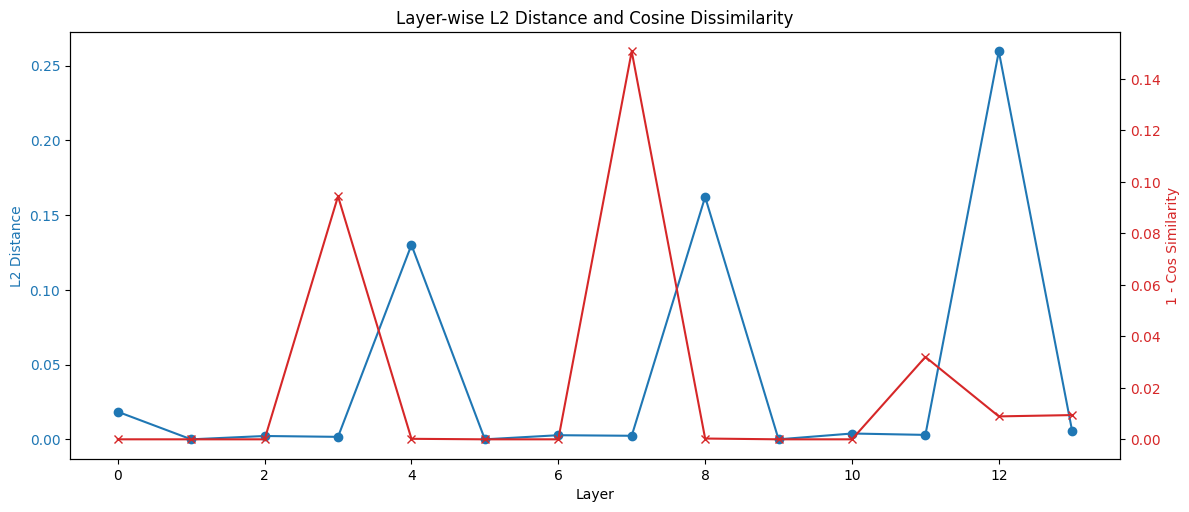

In [ ]:
compare_model_weights(model1, model3)

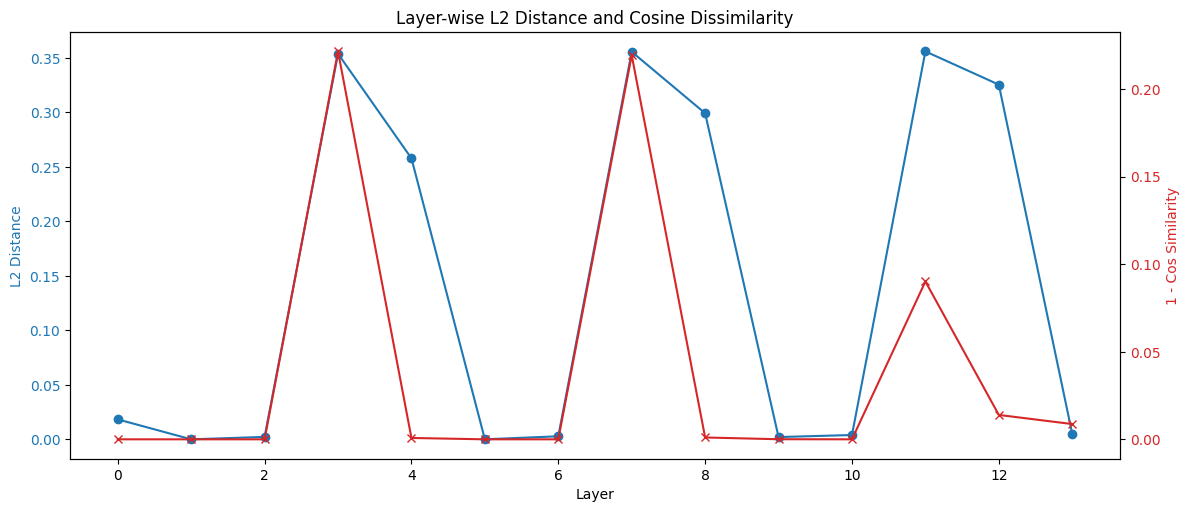

In [178]:
compare_model_weights(model1, model3)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import cosine_similarity

# Define your model architecture
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc = nn.Linear(784, 10)  # Example for FMNIST

    def forward(self, x):
        return self.fc(x)

# Initialize models
model0 = MyModel()
model1 = MyModel()
model3 = MyModel()

# Load pre-trained weights for model0 and model1
# model0.load_state_dict(...)
# model1.load_state_dict(...)

# Define optimizer for model2
optimizer = optim.Adam(model3.parameters(), lr=0.001)

# Hyperparameters
lambda_tradeoff = 1.0  # Trade-off between performance and similarity
budget_B = 0.5  # Maximum allowed cosine similarity

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Compute weight differences
    delta1 = {name: model1.state_dict()[name] - model0.state_dict()[name] for name in model1.state_dict()}
    delta2 = {name: model3.state_dict()[name] - model0.state_dict()[name] for name in model3.state_dict()}

    # Flatten weight differences for cosine similarity calculation
    delta1_flattened = torch.cat([delta1[name].view(-1) for name in delta1])
    delta2_flattened = torch.cat([delta2[name].view(-1) for name in delta2])

    # Compute cosine similarity
    cos_d = cosine_similarity(delta1_flattened, delta2_flattened, dim=0)

    # Compute performance on label-flipped dataset
    outputs = model3(label_flipped_data)
    loss_performance = nn.CrossEntropyLoss()(outputs, label_flipped_labels)

    # Combine into objective function
    objective = loss_performance + lambda_tradeoff * cos_d

    # Backpropagation
    objective.backward()
    optimizer.step()

    # Enforce cosine similarity constraint
    if cos_d > budget_B:
        # Project delta2 back into the feasible region
        scale_factor = budget_B / cos_d
        for name in model3.state_dict():
            model3.state_dict()[name] = model0.state_dict()[name] + (model3.state_dict()[name] - model0.state_dict()[name]) * scale_factor

    # Print progress
    print(f"Epoch {epoch}, Loss: {objective.item()}, Cos Sim: {cos_d.item()}")


1.0004743337631226


In [179]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(10, 2)

    def forward(self, x):
        return self.fc(x)

# Example data
input_data = torch.randn(5, 10)  # Batch of 5 samples, 10 features each
labels = torch.randint(0, 2, (5,))  # Binary labels for 5 samples

# Create model and loss function
model = SimpleModel()
criterion = nn.CrossEntropyLoss()  # Suitable for classification problems

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Forward pass and loss calculation
optimizer.zero_grad()
outputs = model(input_data)
loss = criterion(outputs, labels)

# Compute the gradients of the loss w.r.t. model parameters
loss.backward()

# Compute Fisher Information (approximation via second-order derivatives)
fisher_information = []

# Iterate through each parameter to calculate the second-order derivative
for param in model.parameters():
    # Get the gradient of the parameter
    grad = param.grad
    # Compute the Fisher information as the expected value of the second derivative
    fisher_information.append(torch.matmul(grad.view(-1), grad.view(-1)))

# Fisher information is a sum of the outer products of the gradients
fisher_information = torch.stack(fisher_information)

# Output the Fisher Information matrix
print(fisher_information)


tensor([0.8761, 0.1045])


In [180]:
grad

tensor([-0.2286,  0.2286])